# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles.

## 1. Import necessary libraries and define constants

Import libraries

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
from mpl_toolkits.mplot3d import Axes3D # Axes3D for 3D visualization
import numpy as np                 # NumPy for quick maths
from collections import Counter    # dictionary quick maths
from tem_functions import *        # import necessary functions from separate python file
import timeit                      # timing how long it takes to import libraries
from scipy.optimize import fsolve  # used for solving system of nonlin eqs. (particle intersections)
import warnings                    # used for particle intersections
warnings.filterwarnings("ignore", category=RuntimeWarning) # used for particle intersections
import time                        # timing how long it takes to import libraries
from numba import jit, njit, types, typeof  # optimization library
from numba.typed import Dict, List          # optimized data structures


t_pipe_init = time.perf_counter()  # begin timing pipeline

Define constants

In [2]:
# threshold_1 = 55 # for 36a
# threshold_1 = 99 # for 500nm_epoxy_2
# threshold_2 = 70 # for 500nm_epoxy_15
# threshold_3 = 85 # for 500nm_epoxy_22
threshold_1 = 55 # for 36a
threshold_2 = 35 # for 36b
threshold_3 = 45 # for 36e
# threshold_1 = 55 # for 36h

# nm_per_pixel_1 = 1000 / 131 # In 500nm_epoxy_2.jpg there are 131 pixels per 1 micrometer
# nm_per_pixel_2 = 500 / 108 	# In 500nm_epoxy_15.jpg there are 108 pixels per 0.5 micrometer
# nm_per_pixel_3 = 500 / 127  # In 500nm_epoxy_22.jpg there are 127 pixels per 0.5 micrometer
nm_per_pixel_1 = 100 / 113 	# In TES-II-36a.tif there are 113 pixels per 100 nm
nm_per_pixel_2 = 100 / 113 	# In TES-II-36b.tif there are 113 pixels per 100 nm
nm_per_pixel_3 = 100 / 113 	# In TES-II-36e.tif there are 113 pixels per 100 nm

print(str(expected_radius), "nm is expected particle radius")

100 nm is expected particle radius


## 2. Setup

grayscale, gaussian blur, binary threshold, noise removel, dilation, distance transform

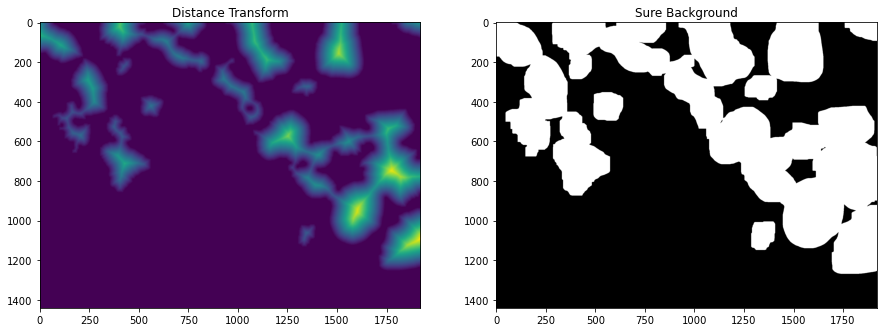

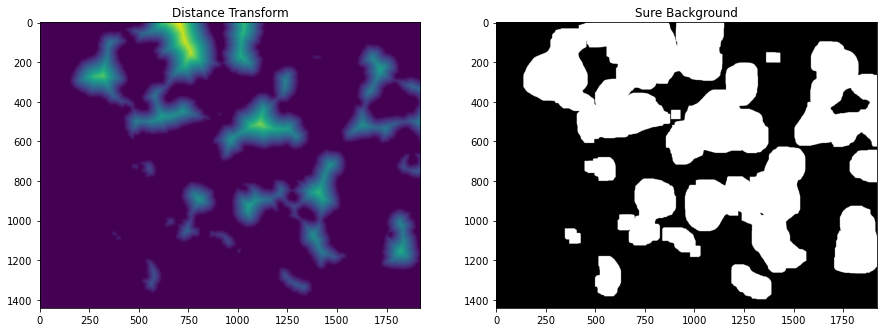

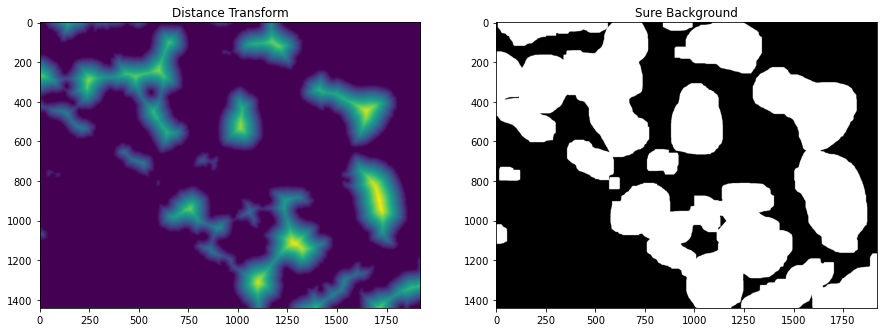

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME_1 = "./inputs/TES-36a-cropped.tif"
IMAGE_NAME_2 = "./inputs/TES-36b-cropped.tif"
IMAGE_NAME_3 = "./inputs/TES-36e-cropped.tif"
# IMAGE_NAME_1 = "./inputs/TES-36h-cropped.tif"
# IMAGE_NAME_1 = "./inputs/500nm_epoxy/500nm_epoxy_2.jpg"
# IMAGE_NAME_2 = "./inputs/500nm_epoxy/500nm_epoxy_15.jpg"
# IMAGE_NAME_3 = "./inputs/500nm_epoxy/500nm_epoxy_22.jpg"

color_image_1, dist_transform_1, sure_bg_1 = setup(IMAGE_NAME_1, threshold_1, False)
color_image_2, dist_transform_2, sure_bg_2 = setup(IMAGE_NAME_2, threshold_2, False)
color_image_3, dist_transform_3, sure_bg_3 = setup(IMAGE_NAME_3, threshold_3, False)

## 3. Perform watershed and find contours

Find the threshold value that will break up agglomerates into individual particles

In [4]:
dist_transform_thresh_1 = get_watershed_threshold(dist_transform_1, sure_bg_1, color_image_1, expected_radius, nm_per_pixel_1)
dist_transform_thresh_2 = get_watershed_threshold(dist_transform_2, sure_bg_2, color_image_2, expected_radius, nm_per_pixel_2)
dist_transform_thresh_3 = get_watershed_threshold(dist_transform_3, sure_bg_3, color_image_3, expected_radius, nm_per_pixel_3)


Get watershed markers

In [5]:
# watershed markers for finding particles (no agglomerates)
watershed_markers_1 = get_watershed_markers(dist_transform_1, dist_transform_thresh_1, sure_bg_1, color_image_1, False)
watershed_markers_2 = get_watershed_markers(dist_transform_2, dist_transform_thresh_2, sure_bg_2, color_image_2, False)
watershed_markers_3 = get_watershed_markers(dist_transform_3, dist_transform_thresh_3, sure_bg_3, color_image_3, False)

# watershed markers for finding agglomerates
agg_watershed_markers_1 = get_watershed_markers(dist_transform_1, 0.1, sure_bg_1, color_image_1, False)
agg_watershed_markers_2 = get_watershed_markers(dist_transform_2, 0.1, sure_bg_2, color_image_2, False)
agg_watershed_markers_3 = get_watershed_markers(dist_transform_3, 0.1, sure_bg_3, color_image_3, False)

Get contours

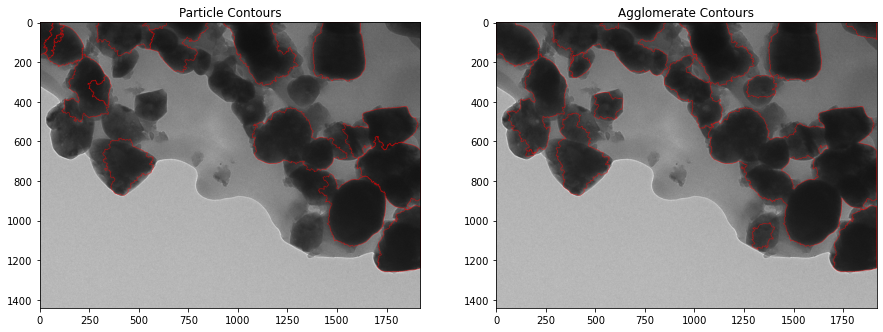

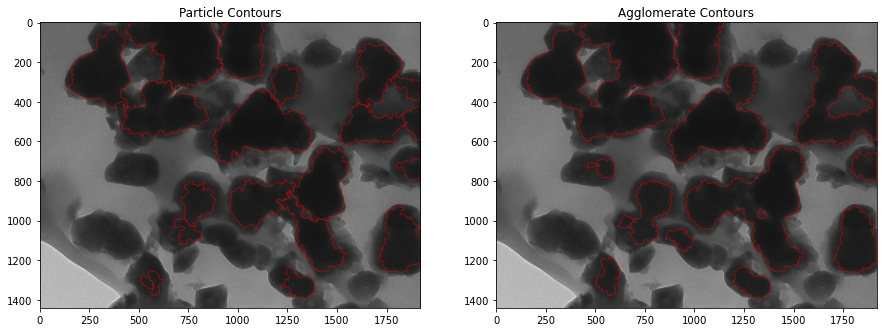

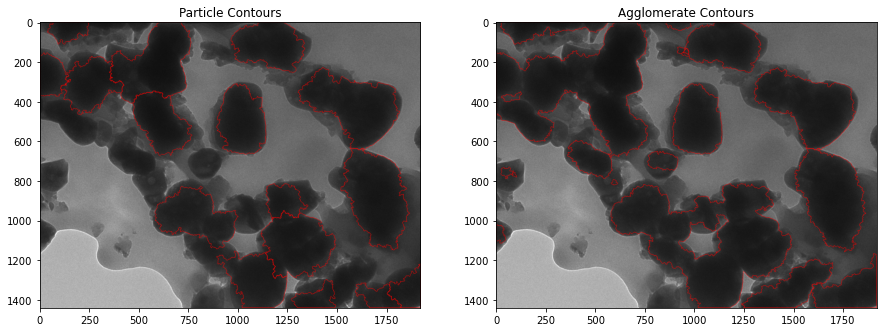

In [6]:
contour_colors_1, chords_color_copy_1 = get_contour_colors(watershed_markers_1, color_image_1)
contour_colors_2, chords_color_copy_2 = get_contour_colors(watershed_markers_2, color_image_2)
contour_colors_3, chords_color_copy_3 = get_contour_colors(watershed_markers_3, color_image_3)

agg_contour_colors_1, agg_chords_color_copy_1 = get_contour_colors(agg_watershed_markers_1, color_image_1)
agg_contour_colors_2, agg_chords_color_copy_2 = get_contour_colors(agg_watershed_markers_2, color_image_2)
agg_contour_colors_3, agg_chords_color_copy_3 = get_contour_colors(agg_watershed_markers_3, color_image_3)

display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Particle Contours", "Agglomerate Contours"], [1, 1])
display_images([chords_color_copy_2, agg_chords_color_copy_2], ["Particle Contours", "Agglomerate Contours"], [1, 1])
display_images([chords_color_copy_3, agg_chords_color_copy_3], ["Particle Contours", "Agglomerate Contours"], [1, 1])

## 4. Finding centerpoints, getting areas, and replacing agglomerates with particles

Finding centerpoints

In [7]:
particles_1 = find_centerpoints(contour_colors_1, nm_per_pixel_1)
particles_2 = find_centerpoints(contour_colors_2, nm_per_pixel_2)
particles_3 = find_centerpoints(contour_colors_3, nm_per_pixel_3)

agg_particles_1 = find_centerpoints(agg_contour_colors_1, nm_per_pixel_1)
agg_particles_2 = find_centerpoints(agg_contour_colors_2, nm_per_pixel_2)
agg_particles_3 = find_centerpoints(agg_contour_colors_3, nm_per_pixel_3)

Getting areas

In [8]:
particle_areas_1 = get_areas(watershed_markers_1, nm_per_pixel_1)
particle_areas_2 = get_areas(watershed_markers_2, nm_per_pixel_2)
particle_areas_3 = get_areas(watershed_markers_3, nm_per_pixel_3)

agg_areas_1 = get_areas(agg_watershed_markers_1, nm_per_pixel_1)
agg_areas_2 = get_areas(agg_watershed_markers_2, nm_per_pixel_2)
agg_areas_3 = get_areas(agg_watershed_markers_3, nm_per_pixel_3)

Replacing agglomerates with particles

In [10]:
merge_particles_1, merge_contour_colors_1 = match_images(particles_1, contour_colors_1, agg_particles_1, agg_contour_colors_1, agg_areas_1, nm_per_pixel_1)
merge_particles_2, merge_contour_colors_2 = match_images(particles_2, contour_colors_2, agg_particles_2, agg_contour_colors_2, agg_areas_2, nm_per_pixel_2)
merge_particles_3, merge_contour_colors_3 = match_images(particles_3, contour_colors_3, agg_particles_3, agg_contour_colors_3, agg_areas_3, nm_per_pixel_3)


## 5. Get long and short chord lengths

Get long chord lengths

In [12]:
long_pairs_1, merge_particles_1, merge_contour_colors_1 = get_long_chord_lengths(merge_particles_1, particles_1, contour_colors_1, merge_contour_colors_1, nm_per_pixel_1)
long_pairs_2, merge_particles_2, merge_contour_colors_2 = get_long_chord_lengths(merge_particles_2, particles_2, contour_colors_2, merge_contour_colors_2, nm_per_pixel_2)
long_pairs_3, merge_particles_3, merge_contour_colors_3 = get_long_chord_lengths(merge_particles_3, particles_3, contour_colors_3, merge_contour_colors_3, nm_per_pixel_3)


Get short chord lengths

In [14]:
short_pairs_1, merge_particles_1 = get_short_chord_lengths(merge_particles_1, merge_contour_colors_1, long_pairs_1, nm_per_pixel_1)
short_pairs_2, merge_particles_2 = get_short_chord_lengths(merge_particles_2, merge_contour_colors_2, long_pairs_2, nm_per_pixel_2)
short_pairs_3, merge_particles_3 = get_short_chord_lengths(merge_particles_3, merge_contour_colors_3, long_pairs_3, nm_per_pixel_3)

In [16]:
merge_particles_1 = break_up_agglomerates(merge_particles_1, merge_contour_colors_1, nm_per_pixel_1, long_pairs_1, short_pairs_1)
merge_particles_2 = break_up_agglomerates(merge_particles_2, merge_contour_colors_2, nm_per_pixel_2, long_pairs_2, short_pairs_2)
merge_particles_3 = break_up_agglomerates(merge_particles_3, merge_contour_colors_3, nm_per_pixel_3, long_pairs_3, short_pairs_3)

Display contours and chord lengths

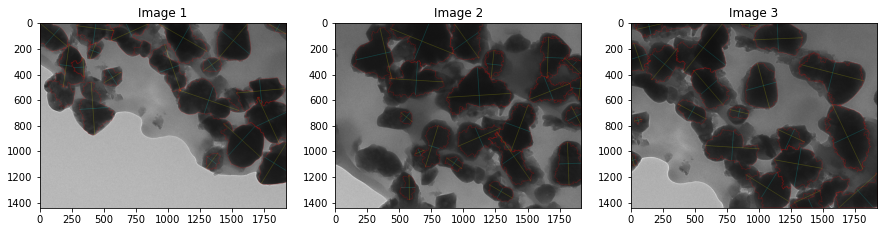

In [21]:
annotated_image_1 = annotate_TEM(color_image_1, long_pairs_1, short_pairs_1, merge_contour_colors_1)
annotated_image_2 = annotate_TEM(color_image_2, long_pairs_2, short_pairs_2, merge_contour_colors_2)
annotated_image_3 = annotate_TEM(color_image_3, long_pairs_3, short_pairs_3, merge_contour_colors_3)

display_images([annotated_image_1, annotated_image_2, annotated_image_3], ["Image 1", "Image 2", "Image 3"], [0, 0, 0])
# plt.savefig("./visualizations/contours_short_chords_abe", dpi=500)

## 6. Get c radii and layer information

In [22]:
merge_particles_1 = get_c(merge_particles_1)
merge_particles_2 = get_c(merge_particles_2)
merge_particles_3 = get_c(merge_particles_3)

# max c model
# merge_particles_1 = set_max_c(merge_particles_1)
# merge_particles_2 = set_max_c(merge_particles_2)
# merge_particles_3 = set_max_c(merge_particles_3)


In [25]:
# add particles if desired

# adding particles to layer b to get to 20% volume loading
# merge_particles_2[30] = [('x', 350), ('y', 900), ('a', 150), ('theta', 0), ('b', 99), ('c', 100)]
# merge_particles_2[31] = [('x', 1250), ('y', 100), ('a', 150), ('theta', 0), ('b', 100), ('c', 100)]
# merge_particles_2[32] = [('x', 750), ('y', 1100), ('a', 130), ('theta', 0), ('b', 75), ('c', 100)]
# merge_particles_2[33] = [('x', 275), ('y', 600), ('a', 150), ('theta', 90), ('b', 80), ('c', 100)]
# merge_particles_2[34] = [('x', 275), ('y', 1100), ('a', 100), ('theta', 0), ('b', 90), ('c', 100)]
# merge_particles_2[35] = [('x', 1000), ('y', 1000), ('a', 100), ('theta', 0), ('b', 90), ('c', 100)]
# merge_particles_2[36] = [('x', 1275), ('y', 350), ('a', 120), ('theta', 90), ('b', 80), ('c', 100)]
# merge_particles_2[37] = [('x', 1475), ('y', 725), ('a', 120), ('theta', 90), ('b', 80), ('c', 100)]
# merge_particles_2[38] = [('x', 625), ('y', 620), ('a', 100), ('theta', 90), ('b', 60), ('c', 100)]
# merge_particles_2[39] = [('x', 1400), ('y', 1100), ('a', 100), ('theta', 90), ('b', 70), ('c', 100)]

In [26]:
# merge_particles_1 = layer_xy_rotate_particles(merge_particles_1)
# intersections = layer_check_intersections(merge_particles_1)
# print(intersections)
merge_particles_1 = layer_scale_particles(merge_particles_1)
merge_particles_2 = layer_scale_particles(merge_particles_2)
merge_particles_3 = layer_scale_particles(merge_particles_3)
# intersections = layer_check_intersections(merge_particles_1)
# print(intersections)

delete duplicate particles in merge_particles dictionaries

In [27]:
num_before = len(merge_particles_1) + len(merge_particles_2) + len(merge_particles_3)
merge_particles_1 = delete_duplicates(merge_particles_1)
merge_particles_2 = delete_duplicates(merge_particles_2)
merge_particles_3 = delete_duplicates(merge_particles_3)
num_after = len(merge_particles_1) + len(merge_particles_2) + len(merge_particles_3)
print(num_before-num_after, "particles deleted")

4 particles deleted


In [28]:
info_1 = get_layer_info(merge_particles_1)
info_2 = get_layer_info(merge_particles_2)
info_3 = get_layer_info(merge_particles_3)

## 7. Render layer

<IPython.core.display.Javascript object>


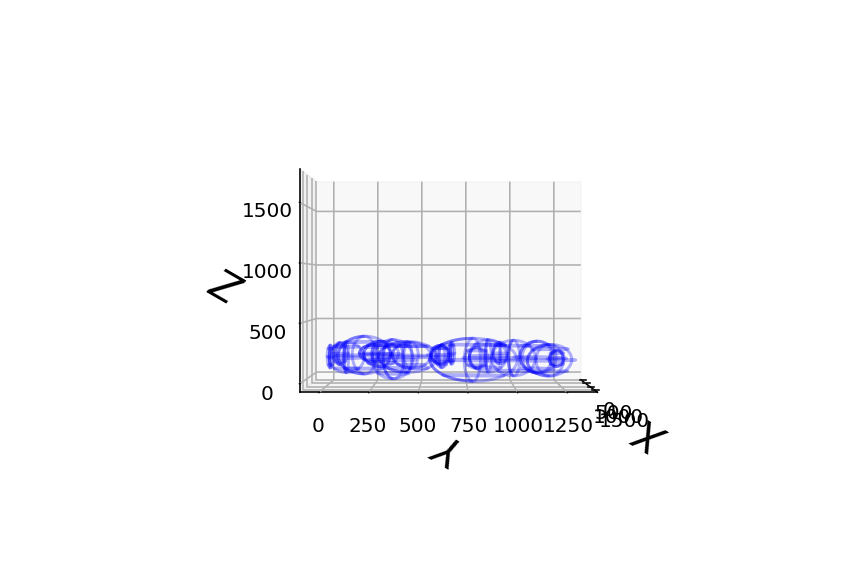

<IPython.core.display.Javascript object>


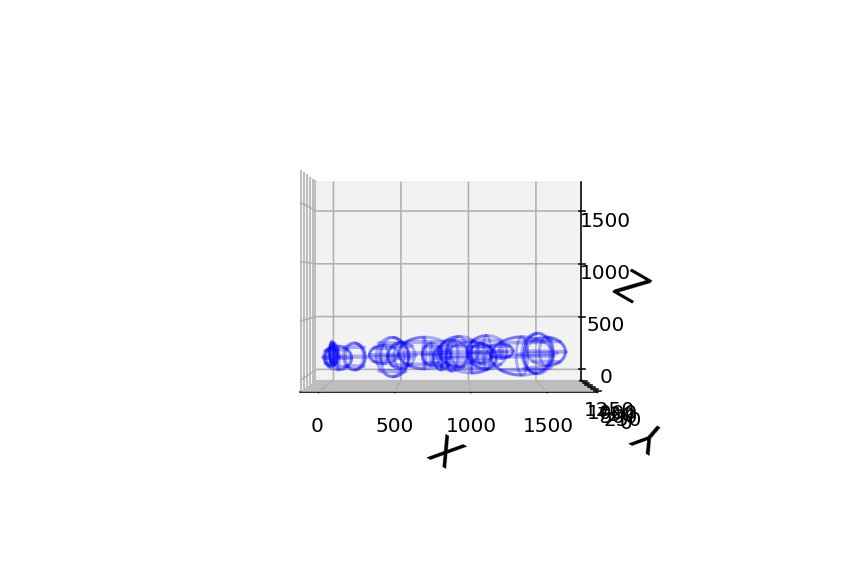

<IPython.core.display.Javascript object>


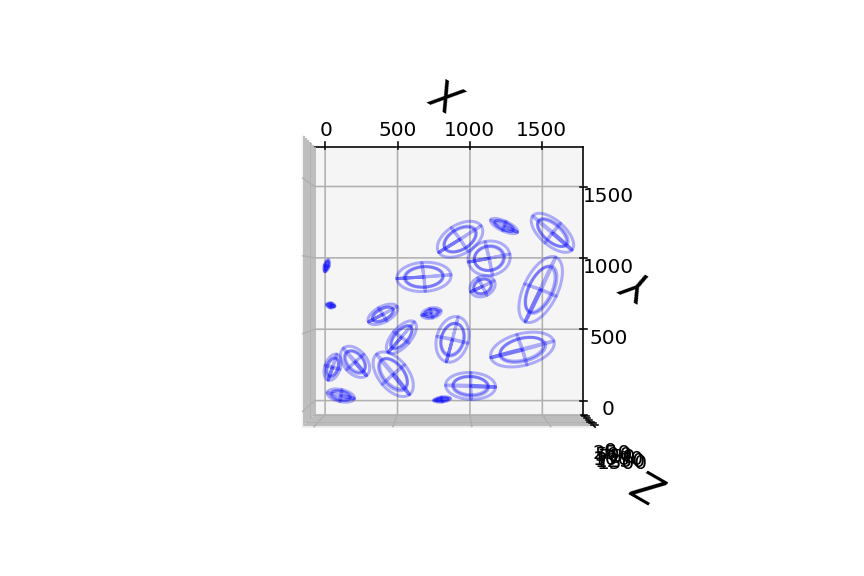

In [49]:
%matplotlib notebook

layer_render(merge_particles_3, info_3)

## 8. Combine layers

In [31]:
composite_particles_123, composite_info_123 = combine_layers([merge_particles_1,merge_particles_2,merge_particles_3], [info_1, info_2, info_3])
# composite_particles_132, composite_info_132 = combine_layers([merge_particles_1,merge_particles_3,merge_particles_2], [info_1, info_3, info_2])
# composite_particles_213, composite_info_213 = combine_layers([merge_particles_2,merge_particles_1,merge_particles_3], [info_2, info_1, info_3])
# composite_particles_231, composite_info_231 = combine_layers([merge_particles_2,merge_particles_3,merge_particles_1], [info_2, info_3, info_1])
# composite_particles_312, composite_info_312 = combine_layers([merge_particles_3,merge_particles_1,merge_particles_2], [info_3, info_1, info_2])
# composite_particles_321, composite_info_321 = combine_layers([merge_particles_3,merge_particles_2,merge_particles_1], [info_3, info_2, info_1])

In [32]:
# composite_particles_23, composite_info_23 = combine_layers([merge_particles_2,merge_particles_3], [info_2, info_3])

# composite_particles_232, composite_info_232 = combine_layers([merge_particles_2,merge_particles_3,merge_particles_2], [info_2, info_3, info_2])


In [33]:
# composite_particles_1, composite_info_1 = combine_layers([merge_particles_1], [info_1])
# composite_particles_2, composite_info_2 = combine_layers([merge_particles_2], [info_2])
# composite_particles_3, composite_info_3 = combine_layers([merge_particles_3], [info_3])

In [34]:
# composite_particles_111, composite_info_111 = combine_layers([merge_particles_1,merge_particles_1,merge_particles_1], [info_1, info_1, info_1])


In [35]:
# decrease volume loading
# composite_particles_123_1, composite_info_123_1 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
# composite_particles_123_2, composite_info_123_2 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
# composite_particles_123_3, composite_info_123_3 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
# composite_particles_123_4, composite_info_123_4 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
# composite_particles_123_5, composite_info_123_5 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
# composite_particles_123_6, composite_info_123_6 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
# composite_particles_123_7, composite_info_123_7 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)

## 9. Get Electrode Metric

In [36]:
# get_electrode_particle_metric(composite_particles_123, composite_info_123)
# get_electrode_particle_metric(composite_particles_132, composite_info_132)
# get_electrode_particle_metric(composite_particles_213, composite_info_213)
# get_electrode_particle_metric(composite_particles_231, composite_info_231)
# get_electrode_particle_metric(composite_particles_312, composite_info_312)
# get_electrode_particle_metric(composite_particles_321, composite_info_321)

# get_electrode_particle_metric(composite_particles_1, composite_info_1)
# get_electrode_particle_metric(composite_particles_2, composite_info_2)
# get_electrode_particle_metric(composite_particles_3, composite_info_3)


In [37]:
# get_electrode_particle_metric(composite_particles_123_1, composite_info_123_1)
# get_electrode_particle_metric(composite_particles_123_2, composite_info_123_2)
# get_electrode_particle_metric(composite_particles_123_3, composite_info_123_3)
# get_electrode_particle_metric(composite_particles_123_4, composite_info_123_4)
# get_electrode_particle_metric(composite_particles_123_5, composite_info_123_5)
# get_electrode_particle_metric(composite_particles_123_6, composite_info_123_6)
# get_electrode_particle_metric(composite_particles_123_7, composite_info_123_7)

In [38]:
# get_electrode_particle_metric(composite_particles_232, composite_info_232)

In [41]:
# get_electrode_particle_metric(composite_particles_111, composite_info_111)

## 10. Render Composite

<IPython.core.display.Javascript object>


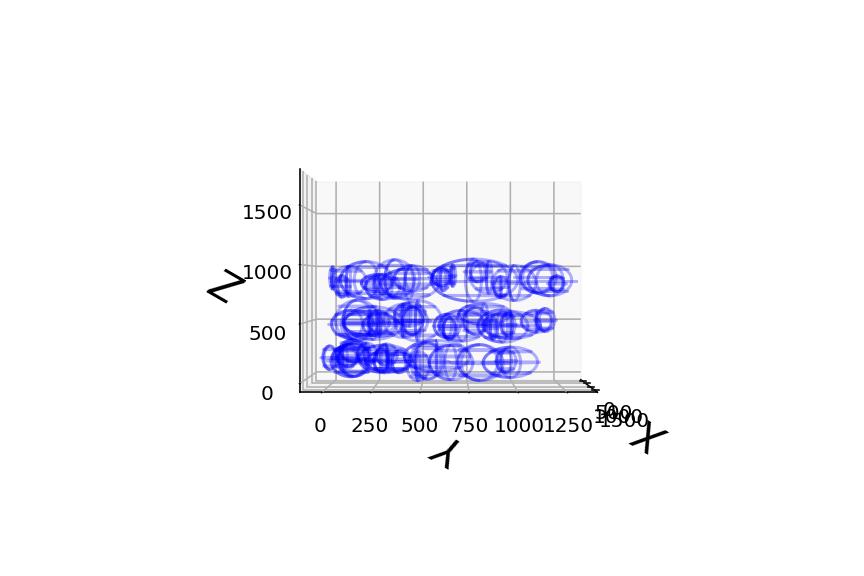

<IPython.core.display.Javascript object>


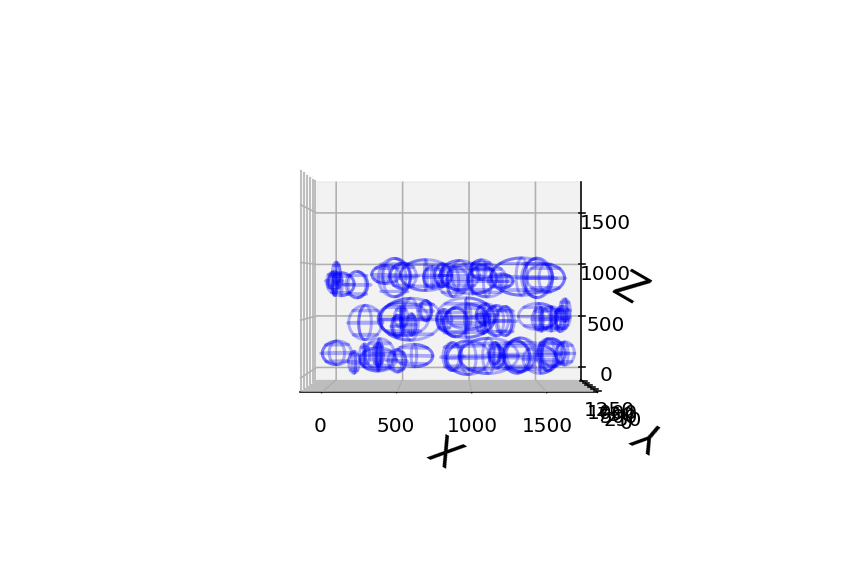

<IPython.core.display.Javascript object>


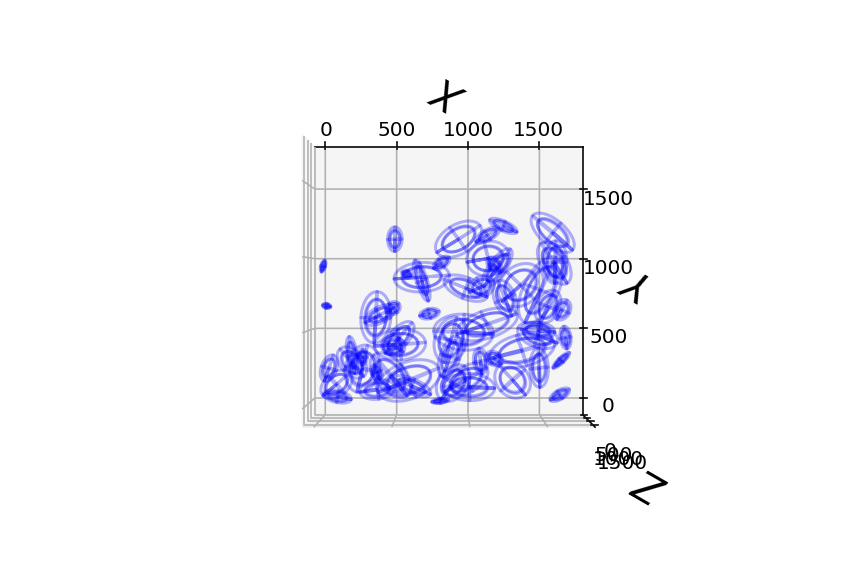

In [42]:
%matplotlib notebook

composite_render(composite_particles_123, composite_info_123)

## 11. Save to a text file

In [43]:
# generate_text_file(composite_particles_123, composite_info_123, "./outputs/11_04_21_500nm_2_15_22.txt")
# generate_text_file(composite_particles_132, composite_info_132, "./outputs/11_04_21_500nm_2_22_15.txt")
# generate_text_file(composite_particles_213, composite_info_213, "./outputs/11_04_21_500nm_15_2_22.txt")
# generate_text_file(composite_particles_231, composite_info_231, "./outputs/11_04_21_500nm_15_22_2.txt")
# generate_text_file(composite_particles_312, composite_info_312, "./outputs/11_04_21_500nm_22_2_15.txt")
# generate_text_file(composite_particles_321, composite_info_321, "./outputs/11_04_21_500nm_22_15_22.txt")

In [44]:
# generate_text_file(composite_particles_123_1, composite_info_123_1, "./outputs/14_04_21_abe_10_vol_loading_1.txt")
# generate_text_file(composite_particles_123_2, composite_info_123_2, "./outputs/14_04_21_abe_10_vol_loading_2.txt")
# generate_text_file(composite_particles_123_3, composite_info_123_3, "./outputs/14_04_21_abe_10_vol_loading_3.txt")
# generate_text_file(composite_particles_123_4, composite_info_123_4, "./outputs/14_04_21_abe_10_vol_loading_4.txt")
# generate_text_file(composite_particles_123_5, composite_info_123_5, "./outputs/14_04_21_abe_10_vol_loading_5.txt")
# generate_text_file(composite_particles_123_6, composite_info_123_6, "./outputs/14_04_21_abe_10_vol_loading_6.txt")
# generate_text_file(composite_particles_123_7, composite_info_123_7, "./outputs/14_04_21_abe_10_vol_loading_7.txt")

In [45]:
# generate_text_file(composite_particles_23, composite_info_23, "two_layer_be.txt")

# generate_text_file(composite_particles_111, composite_info_111, "./outputs/11_04_21_500nm_2_2_2.txt")

# generate_text_file(composite_particles_232, composite_info_232, "./outputs/11_04_21_500nm_15_22_15.txt")

In [46]:
# generate_text_file(composite_particles_1, composite_info_1, "./outputs/11_04_21_500nm_2.txt")
# generate_text_file(composite_particles_2, composite_info_2, "./outputs/11_04_21_500nm_15.txt")
# generate_text_file(composite_particles_3, composite_info_3, "./outputs/11_04_21_500nm_22.txt")

## 11. Time to Run Pipeline

In [47]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 396.2254711179994 seconds
